Assignment 7; Michael Bishop Kaggle 'Wine Dataset for Clustering'

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.stats import chi2

# Load dataset 
wine_data = pd.read_csv('/drive/data/wine-clustering.csv')
wine_data.columns


Index(['Alcohol', 'Malic_Acid', 'Ash', 'Ash_Alcanity', 'Magnesium',
       'Total_Phenols', 'Flavanoids', 'Nonflavanoid_Phenols',
       'Proanthocyanins', 'Color_Intensity', 'Hue', 'OD280', 'Proline'],
      dtype='object')

Determinant of correlation matrix: 0.000469 (small p-value indicates factorability)
Bartlett's test: chi-square=1317.18, df=78, p-value=0.000 (small p-value indicates suitability)


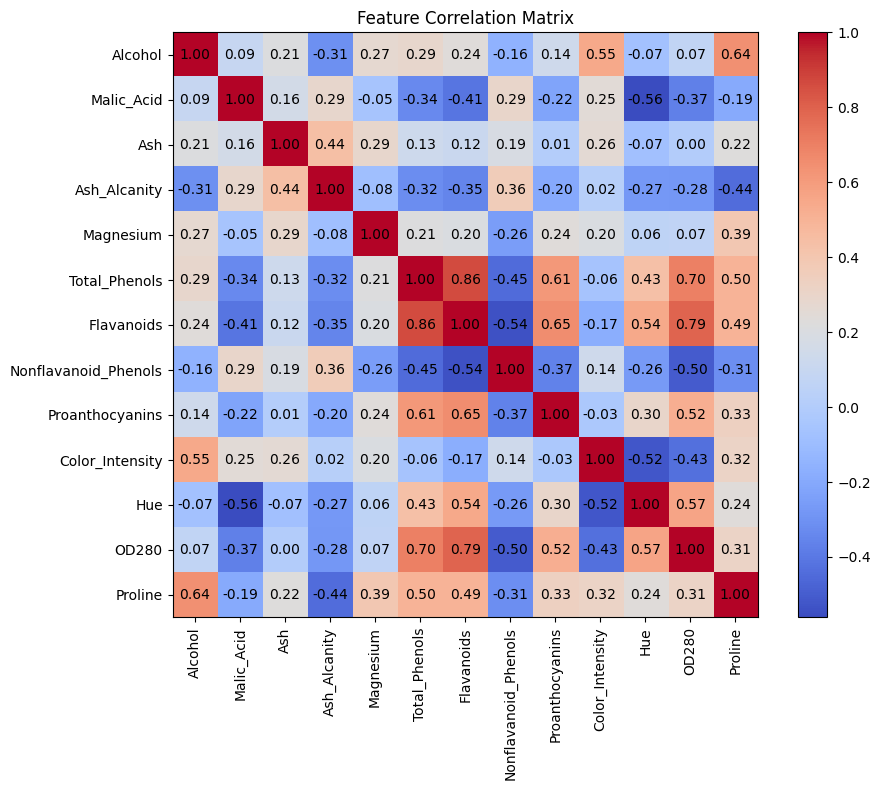

In [30]:
# Standardize data
scaler = StandardScaler()
wine_scaled = scaler.fit_transform(wine_data)

columns = [
    'Alcohol', 'Malic_Acid', 'Ash', 'Ash_Alcanity', 'Magnesium',
    'Total_Phenols', 'Flavanoids', 'Nonflavanoid_Phenols', 'Proanthocyanins',
    'Color_Intensity', 'Hue', 'OD280', 'Proline'
]

# Assumption Checks

# 1. Check determinant of correlation matrix (factorability proxy)
corr_matrix = pd.DataFrame(wine_scaled, columns=columns).corr()
det = np.linalg.det(corr_matrix)
n, p = wine_scaled.shape
# Bartlett's test of sphericity 
chi_square_value = -(n - 1 - (2 * p + 5) / 6) * np.log(det)
df = p * (p - 1) / 2
p_value = 1 - chi2.cdf(chi_square_value, df)

print(f"Determinant of correlation matrix: {det:.6f} (small p-value indicates factorability)")
print(f"Bartlett's test: chi-square={chi_square_value:.2f}, df={int(df)}, p-value={p_value:.3f} (small p-value indicates suitability)")

# 2. Multicollinearity: correlation heatmap using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(columns)), columns, rotation=90)
plt.yticks(range(len(columns)), columns)
for i in range(len(columns)):
    for j in range(len(columns)):
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black')
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# Perform PCA
pca = PCA()
wine_pca = pca.fit_transform(wine_scaled)


Above assumption checks yield a favorable situation for PCA, as we have evidence of factorability, as well as evidence of suitability from Bartlett's test. When looking at the correlation heatmap to judge for multi-collinearity, we see that Total_Phenols, and Flavanoids have the largest correlation at 0.86, and are related to OD280 with a correlation of 0.70 and 0.79 respectively. While there may be some evidence of stronger correlations there, in general, the variables seem to be not too strongly correlated, suggesting reasonable candidacy for PCA.

Number of components needed for 80% variance: 5


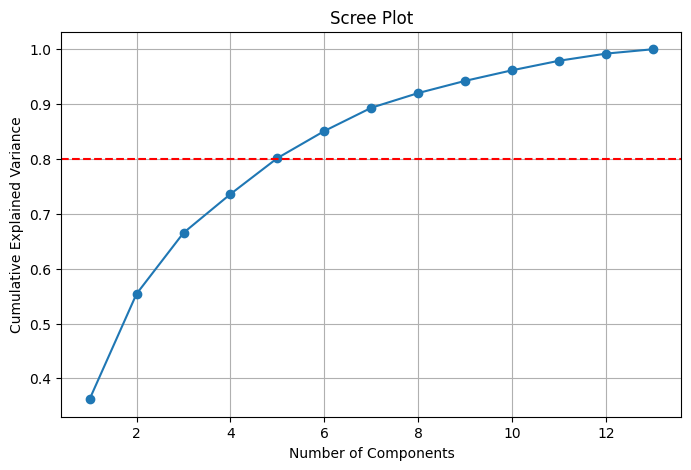

In [31]:
# Determine number of components for 80% variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.80) + 1
print(f"Number of components needed for 80% variance: {n_components}")

# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.axhline(0.80, color='r', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

# Apply PCA with selected components
pca = PCA(n_components=n_components)
wine_pca_reduced = pca.fit_transform(wine_scaled)

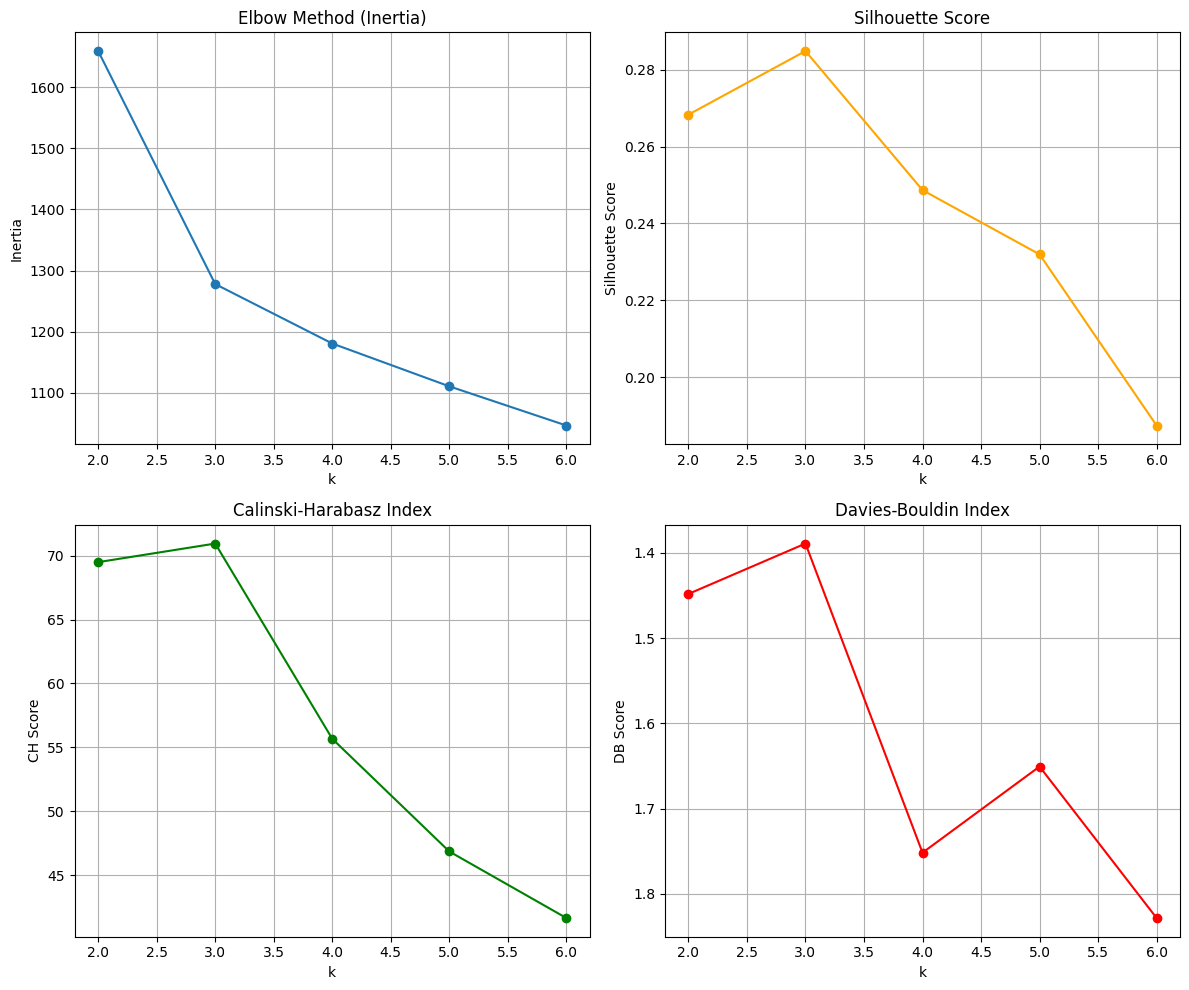

In [14]:
# K-Means clustering: evaluate inertia, silhouette, Calinski-Harabasz, Davies-Bouldin
k_values = range(2, 7)
inertia = []
silhouette = []
calinski_harabasz = []
davies_bouldin = []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=1234, n_init=10)
    labels = km.fit_predict(wine_pca)
    inertia.append(km.inertia_)
    silhouette.append(silhouette_score(wine_pca, labels))
    calinski_harabasz.append(calinski_harabasz_score(wine_pca, labels))
    davies_bouldin.append(davies_bouldin_score(wine_pca, labels))

# Plot metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

axes[0].plot(k_values, inertia, marker='o')
axes[0].set_title('Elbow Method (Inertia)')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inertia') #look for the 'elbow' the point where the slope changes in a dramatic fashion (not super clear here, but leaning towards 3)
axes[0].grid(True)

axes[1].plot(k_values, silhouette, marker='o', color='orange')
axes[1].set_title('Silhouette Score')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Silhouette Score') #higher is better
axes[1].grid(True)

axes[2].plot(k_values, calinski_harabasz, marker='o', color='green')
axes[2].set_title('Calinski-Harabasz Index')
axes[2].set_xlabel('k')
axes[2].set_ylabel('CH Score') # higher is better
axes[2].grid(True)

axes[3].plot(k_values, davies_bouldin, marker='o', color='red')
axes[3].set_title('Davies-Bouldin Index')
axes[3].set_xlabel('k')
axes[3].set_ylabel('DB Score')
axes[3].invert_yaxis()  # lower is better
axes[3].grid(True)

plt.tight_layout()
plt.show()

Above, we see the 4 plots for the inertia, Silhouette Score, Calinski-Harabasz Index Score, and the Davies-Bouldin Index Score across different numbers of clusters (k). Inertia, CH, and Silhouette scores all point to using 3 clusters, while D-B points to using 4. I will be moving forward with 3 clusters.

In [16]:
best_k = k_values[np.argmax(silhouette)]
print(f"Optimal k by silhouette score: {best_k}")

# Final K-Means clustering with best_k
kmeans = KMeans(n_clusters=best_k, random_state=1234, n_init=10)
wine_data['Cluster'] = kmeans.fit_predict(wine_pca)


Optimal k by silhouette score: 3


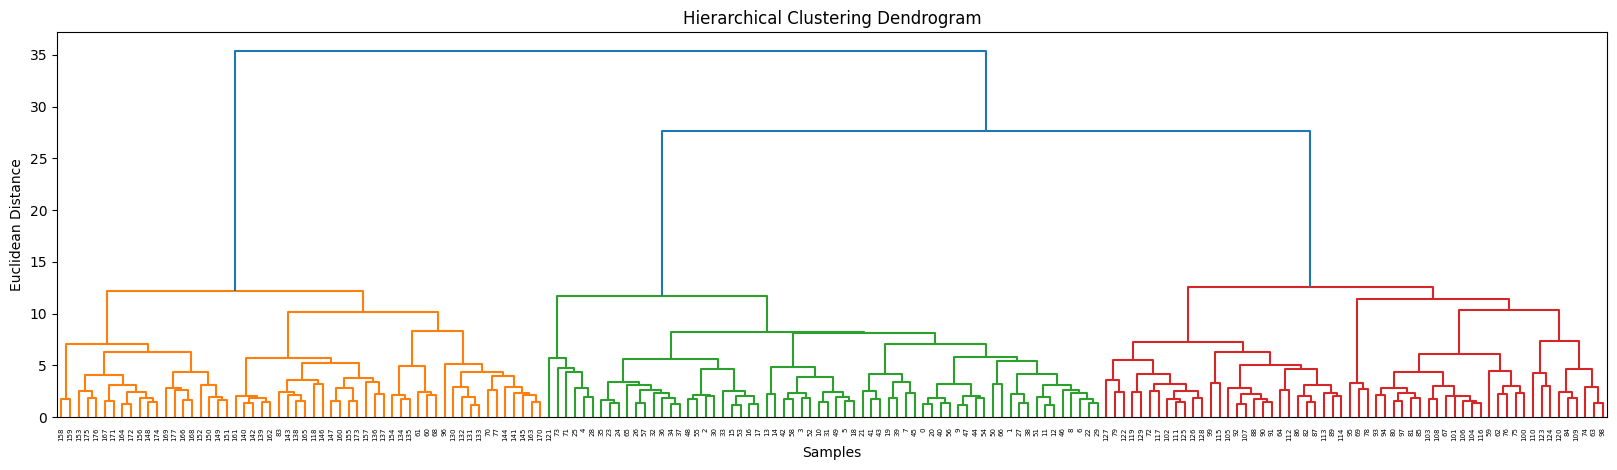

PCA Explained Variance Ratio:
[0.36198848 0.1920749  0.11123631 0.0706903  0.06563294]

Cluster Centers (in PCA-reduced space):
[[-2.72003575e+00  1.12565126e+00 -2.39093241e-01  6.24569372e-02
   7.36759999e-02 -9.99252193e-02 -6.03831729e-02  7.38798948e-03
  -2.00269270e-02 -6.14683784e-02 -8.11598488e-03 -3.45518279e-03
  -5.05509102e-02]
 [ 2.27619360e+00  9.32054027e-01  1.52803156e-03 -1.35498147e-01
  -1.34912110e-01  2.18283242e-01  5.21099249e-02 -2.49642497e-02
   5.02855192e-02  7.46793027e-02  2.12907099e-02  7.43830113e-03
   5.06192498e-02]
 [-3.69566084e-02 -1.77223945e+00  1.86138728e-01  8.02397126e-02
   7.08780744e-02 -1.29805766e-01 -2.32728507e-03  1.80153234e-02
  -3.22512140e-02 -2.30035303e-02 -1.39401351e-02 -4.38400536e-03
  -8.61995490e-03]]

Wine data with assigned clusters (first 5 rows):
   Alcohol  Malic_Acid   Ash  Ash_Alcanity  Magnesium  Total_Phenols  \
0    14.23        1.71  2.43          15.6        127           2.80   
1    13.20        1.78  2.

array([ 0.48365155,  0.22493093,  0.31606881, -0.0105905 ,  0.299634  ,
        0.06503951, -0.00335981,  0.02877949,  0.03930172,  0.52999567,
       -0.27923515, -0.16449619,  0.36490283])

In [34]:
# Hierarchical Clustering
distances = linkage(wine_pca, method='ward')
plt.figure(figsize=(20, 5))
dendrogram(distances)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Euclidean Distance")
plt.show()

# Interpretation summary
print("PCA Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

print("\nCluster Centers (in PCA-reduced space):")
print(kmeans.cluster_centers_)

print("\nWine data with assigned clusters (first 5 rows):")
print(wine_data.head())

pca.components_[0]